In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

# 1. Problem

In this notebook we will simulate genetic optimization of masks to perform wavefront correction.

(np.float64(-0.5), np.float64(511.5), np.float64(383.5), np.float64(-0.5))

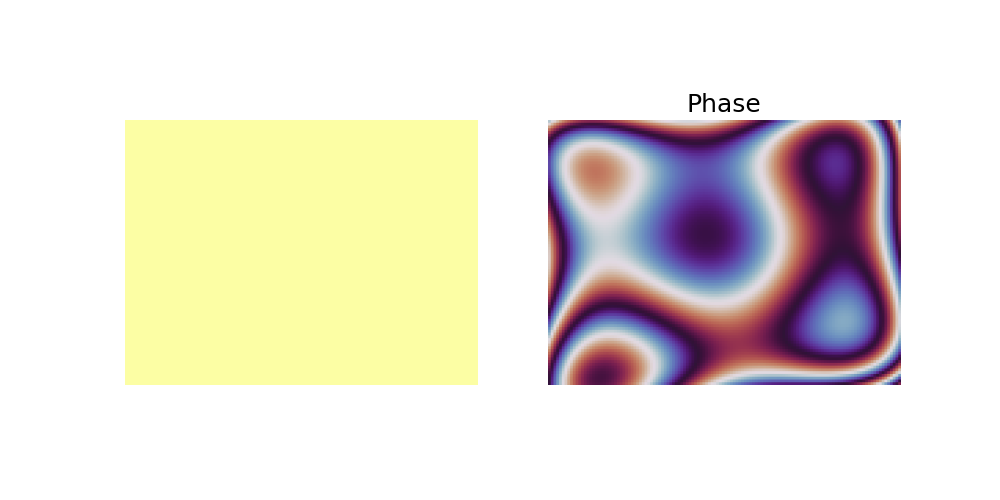

In [2]:
aberration = np.load('aberration.npy')
skip_step = 2
field = 1.0 * np.exp(1j * aberration[::skip_step, ::skip_step])
ny, nx = field.shape

fig, axs = plt.subplots(1, 2, figsize = (10, 5))

ax = axs[0]
ax.imshow(np.abs(field)**2, cmap = 'inferno', vmin = 0, vmax = 1)
ax.axis('off')

ax = axs[1]
ax.set_title("Phase", fontsize = 18)
ax.imshow(np.angle(field), cmap = 'twilight')
ax.axis('off')

## 1.1 Point-Spread Function

The point spread function (PSF) describes the response of a focused optical imaging system to an idealized point source of light. Assuming coherent illumination, we can simulate focusing this light field by applying the fourier transform

(np.float64(-0.5), np.float64(511.5), np.float64(383.5), np.float64(-0.5))

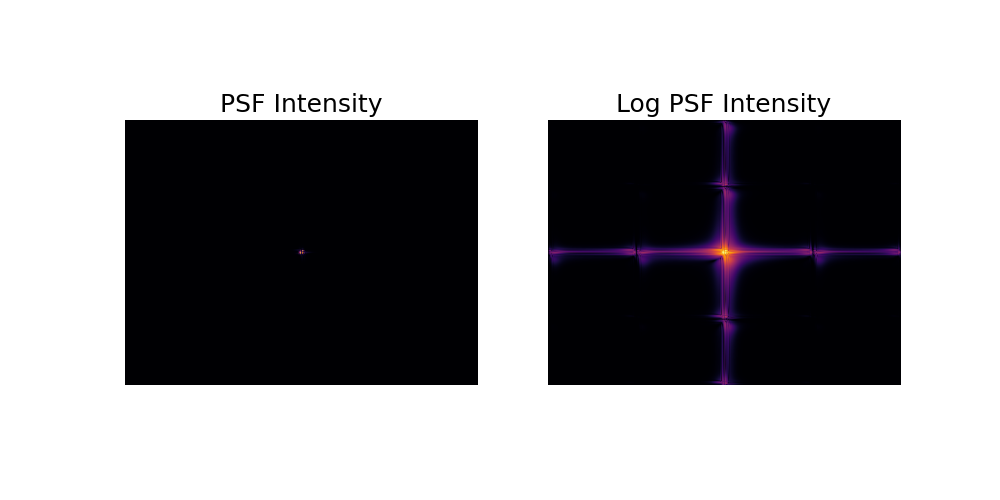

In [3]:
psf = np.fft.fftshift(np.fft.fft2(field))
psf_intensity = np.abs(psf)**2 / np.max(np.abs(psf)**2)

fig, axs = plt.subplots(1, 2, figsize = (10, 5))

ax = axs[0]
ax.set_title("PSF Intensity", fontsize = 18)
ax.imshow(psf_intensity, cmap = 'inferno', vmin = 0, vmax = 1)
ax.axis('off')

ax = axs[1]
ax.set_title("Log PSF Intensity", fontsize = 18)
ax.imshow(np.log10(psf_intensity + 1e-6), cmap = 'inferno')
ax.axis('off')

In [4]:
def simulate_psf(field):
    psf = np.fft.fftshift(np.fft.fft2(field))
    psf_intensity = np.abs(psf) ** 2 / np.sum(np.abs(psf) ** 2)
    return psf_intensity

def fitness_function(psf_intensity, radius = 3):
    cx, cy = psf_intensity.shape[1] // 2, psf_intensity.shape[0] // 2
    y, x = np.ogrid[:psf_intensity.shape[0], :psf_intensity.shape[1]]
    mask = (x - cx)**2 + (y - cy)**2 <= radius**2
    return np.sum(psf_intensity[mask])

# 2. Genetic Optimization

Genetic optimization is employed here to search for a phase mask that reshapes an optical field so that we can maximize the power in the centre of the PSF function. At each iteration, masks that produce tighter focusing are identified as more “fit,” and these are used to generate new masks through crossover and mutation. Repeating this process over various generations will make the population gradually converge toward a phase configuration that maximizes our metric.

1. Generate an initial population of random coarse phase masks.
1. Expand each coarse mask into a full-resolution phase mask using macro-pixel tiling.
1. Propagate the masked field to the Fourier plane and compute the PSF intensity.
1. Evaluate the fitness by summing the PSF intensity inside a small central disk.
1. Select the top-performing masks as parents based on their fitness.
1. Create new candidate masks through pixel-wise crossover between parent masks.
1. Introduce random mutations in the child masks to maintain population diversity.
1. Assemble the next generation by combining parents and mutated offspring.
1. Record the best fitness and update the best mask found so far.
1. Repeat the optimization loop for the specified number of generations.

In [ ]:
def generate_initial_population(pop_size, field_shape, macro_pixels = 8):
    H, W = field_shape
    ny, nx = H // macro_pixels, W // macro_pixels
    return [np.random.uniform(0, 2*np.pi, size = (ny, nx)) for _ in range(pop_size)]

def expand_mask(coarse_mask, macro_pixels):
    return np.kron(coarse_mask, np.ones((macro_pixels, macro_pixels)))

def select_parents(population, fitnesses, num_parents):
    top_idx = np.argsort(fitnesses)[-num_parents:]
    return [population[i] for i in top_idx]

def crossover(parent1, parent2):
    mask = np.random.rand(*parent1.shape) < 0.5
    return np.where(mask, parent1, parent2)

def mutate(coarse_mask, mutation_rate = 0.011, mutation_sigma = 0.02):
    mutation_mask = np.random.rand(*coarse_mask.shape) < mutation_rate
    random_phases = np.random.rand(*coarse_mask.shape) * 2* np.pi * mutation_sigma
    return np.where(mutation_mask, random_phases, coarse_mask)

In [39]:
def genetic_optimization(field, pop_size = 50, num_generations = 100, num_parents = 10, mutation_rate = 0.5, mutation_sigma = 0.02, macro_pixels = 8):

    H, W = field.shape
    population = generate_initial_population(pop_size, (H, W), macro_pixels)

    best_fitness_progress = []
    best_coarse_mask = None
    best_fitness = -np.inf

    for gen in range(num_generations):
        fitnesses = []

        for coarse_mask in population:
            full_mask = expand_mask(coarse_mask, macro_pixels)
            modified_field = field * np.exp(1j * full_mask)
            psf_intensity = simulate_psf(modified_field)
            fitness = fitness_function(psf_intensity)
            fitnesses.append(fitness)

        fitnesses = np.asarray(fitnesses)
        gen_best = float(fitnesses.max())
        best_fitness_progress.append(gen_best)

        if gen_best > best_fitness:
            best_fitness = gen_best
            best_coarse_mask = population[int(fitnesses.argmax())]

        parents = select_parents(population, fitnesses, num_parents)

        new_population = parents.copy()
        while len(new_population) < pop_size:
            i1, i2 = np.random.choice(len(parents), 2, replace = False)
            child = crossover(parents[i1], parents[i2])
            child = mutate(child, mutation_rate, mutation_sigma)
            new_population.append(child)

        population = new_population
        print(f"Generation {gen + 1}/{num_generations}, Best Fitness: {gen_best:.4f}", end = "\r")

    best_full_mask = expand_mask(best_coarse_mask, macro_pixels)
    return best_full_mask, best_fitness_progress

In [38]:
initial_field = field.copy()
macro_pixels = 8

best_phase_mask, fitness_progress = genetic_optimization(
    initial_field, 
    pop_size = 50, 
    num_generations = 50, 
    num_parents = 10, 
    mutation_rate = 0.8, 
    mutation_sigma = 0.025, 
    macro_pixels = macro_pixels)

(np.float64(-0.5), np.float64(1023.5), np.float64(767.5), np.float64(-0.5))

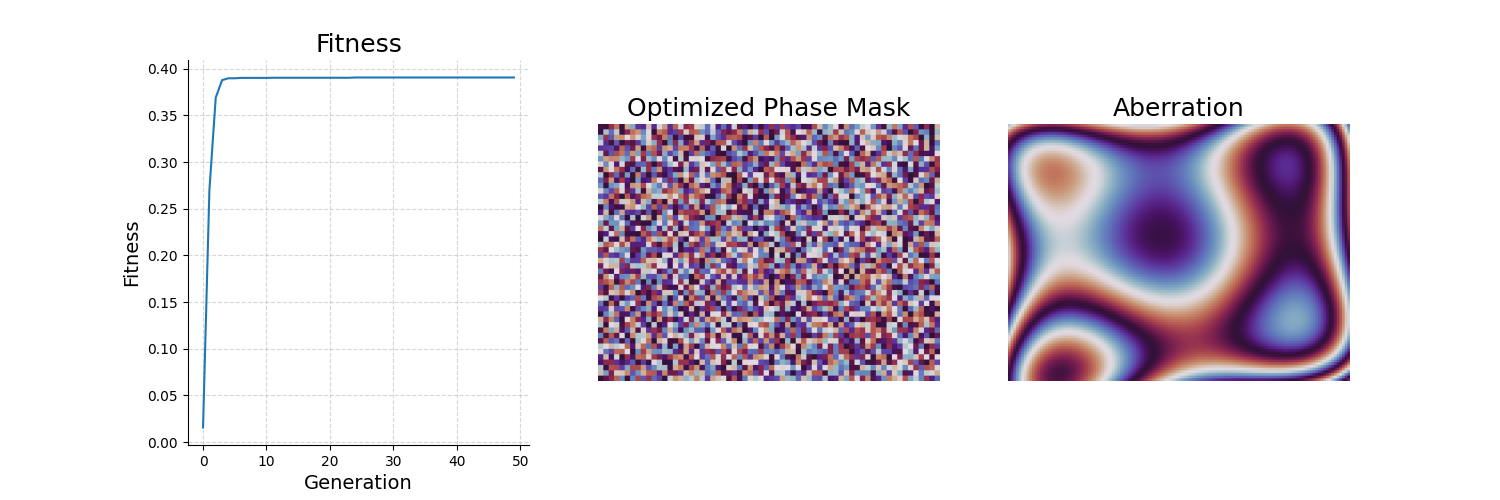

In [33]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

ax = axs[0]
ax.set_title("Fitness", fontsize = 18)
ax.plot(fitness_progress)
ax.set_xlabel("Generation", fontsize = 14)
ax.set_ylabel("Fitness", fontsize = 14)
ax.spines[['top', 'right']].set_visible(False)
ax.grid(visible = True, linestyle = '--', alpha = 0.5)

ax = axs[1]
ax.set_title("Optimized Phase Mask", fontsize = 18) 
ax.imshow(best_phase_mask, cmap = 'twilight')
ax.axis('off')

ax = axs[2]
ax.set_title("Aberration", fontsize = 18)
ax.imshow(aberration, cmap = 'twilight')
ax.axis('off')

## 2.1 Cross-entropy method

The cross-entropy method is used to optimize a phase mask by iteratively refining a probability distribution over all possible masks. Instead of evolving a population via selection and mutation (as in genetic algorithms), CEM repeatedly samples many candidate masks from a parameterized distribution (here, a Gaussian over phase values), evaluates their performance, and then updates the distribution parameters (mean and variance) using only the best “elite” candidates. Over iterations, the distribution collapses around high-performing solutions, and its mean converges toward an optimized phase configuration that concentrates the PSF energy where we want it.

1. Start from an initial coarse phase mask and use it to initialize the mean of a Gaussian distribution over masks.
1. Initialize the standard deviation map to a finite value to allow sufficient exploration of the phase space.
1. At each iteration, draw a batch of coarse phase mask samples from the current Gaussian distribution.
1. Wrap all sampled phase values into the 0-2π interval using a modulo operation.
1. For each sampled mask, expand it to full resolution using macro-pixel tiling.
1. Apply the expanded mask to the input field and compute the corresponding PSF intensity.
1. Evaluate the fitness of each sample by measuring the PSF energy inside a small target region.
1. Select the top-performing samples (the elite set) according to their fitness values.
1. Update the mean mask by computing the circular (phase-aware) average of the elite samples.
1. Update the standard deviation map using the circular spread of the elite samples around the new mean.
1. Enforce a minimum standard deviation to prevent premature collapse of the distribution.
1. Track and store the best-performing mask and its fitness across iterations.
1. Repeat the sampling, evaluation, and update steps for the desired number of iterations.

In [ ]:
def cross_entropy_optimization(field, initial_coarse_mask, macro_pixels = 8, num_iterations = 30, 
                               sample_size = 60, elite_frac = 0.2, min_std = 0.1):

    coarse = initial_coarse_mask.copy()
    ny, nx = coarse.shape

    # Initialize the distribution parameters (mean and std of the mask samples)
    mean = coarse.copy()
    std = np.ones_like(coarse) * min_std

    # Number of elite samples to keep
    elite_count = max(1, int(sample_size * elite_frac))

    # Track best solution found so far
    best_mask = coarse.copy()
    best_fitness = -np.inf

    for it in range(num_iterations):

        # Sample coarse masks from the current distribution
        samples = np.random.normal(mean, std, size = (sample_size, ny, nx))
        samples = np.mod(samples, 2 * np.pi)  # wrap phases into [0, 2π)

        fitnesses = np.zeros(sample_size)

        # Evaluate fitness for each sampled mask
        for i in range(sample_size):
            full_mask = np.kron(samples[i], np.ones((macro_pixels, macro_pixels)))
            mod_field = field * np.exp(1j * full_mask)
            psf = simulate_psf(mod_field)
            fitnesses[i] = fitness_function(psf, radius = 1)

        # Select elite samples (top performers)
        elite_idx = np.argsort(fitnesses)[-elite_count:]
        elite_samples = samples[elite_idx]

        # Update mean (careful with circular nature of phases)
        mean = np.angle(np.mean(np.exp(1j * elite_samples), axis = 0))
        mean = np.mod(mean, 2 * np.pi)

        # Update std (circular aware)
        diff = np.angle(np.exp(1j * (elite_samples - mean)))
        std = np.sqrt(np.mean(diff**2, axis = 0))
        std = np.maximum(std, min_std)  # prevent collapse

        # Track best mask seen during the optimization
        top_fitness = fitnesses[elite_idx[-1]]
        if top_fitness > best_fitness:
            best_fitness = top_fitness
            best_mask = elite_samples[-1]

        print(f"CEM Iter {it+1}/{num_iterations}, Best Fitness: {best_fitness:.4f}", end = "\r")

    # Expand best coarse mask to full resolution and return
    final_full_mask = np.kron(best_mask, np.ones((macro_pixels, macro_pixels)))
    return final_full_mask, best_mask

In [19]:
best_mask_cem, best_coarse_cem = cross_entropy_optimization(
        field = field,
        initial_coarse_mask = best_phase_mask[::macro_pixels, ::macro_pixels],
        macro_pixels = macro_pixels,
        num_iterations = 50,
        sample_size = 60,
        elite_frac = 0.15
    )

(np.float64(-0.5), np.float64(511.5), np.float64(383.5), np.float64(-0.5))

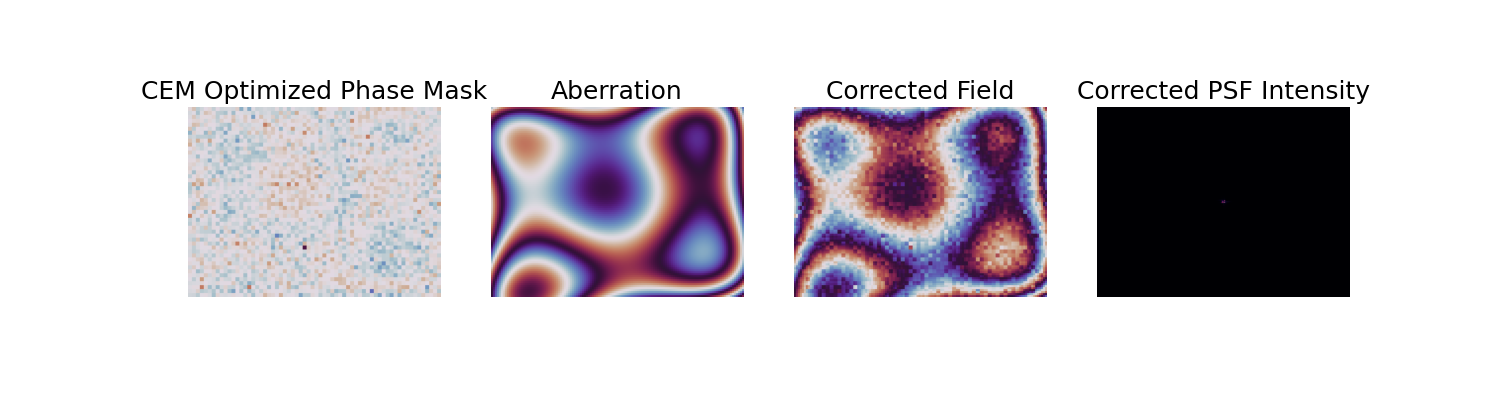

In [20]:
fig, axs = plt.subplots(1, 4, figsize = (15, 4))

ax = axs[0]
ax.set_title("CEM Optimized Phase Mask", fontsize = 18)
ax.imshow(best_mask_cem, cmap = 'twilight')
ax.axis('off')

ax = axs[1]
ax.set_title("Aberration", fontsize = 18)
ax.imshow(np.angle(field), cmap = 'twilight')
ax.axis('off')

ax = axs[2]
ax.set_title("Corrected Field", fontsize = 18)
ax.imshow(np.angle(np.exp(1j * (best_mask_cem - np.angle(field)))), cmap = 'twilight')
ax.axis('off')

ax = axs[3]
ax.set_title("Corrected PSF Intensity", fontsize = 18)
corrected_field = field * np.exp(1j * (best_mask_cem))
corrected_psf = simulate_psf(corrected_field)
ax.imshow(corrected_psf, cmap = 'inferno')
ax.axis('off')

## 2.2 GA extended

The new version takes longer because it doesn’t focus only on the very best individuals right away.
It keeps weaker candidates in the mix and adds small, local mutations instead of replacing phases completely, so the population doesn’t collapse into a single pattern too quickly.
Because the population stays diverse, the algorithm keeps exploring new directions instead of getting stuck after a few generations.

Main differences are:

- Selection changes from  truncation to tournament ->  more diversity.

- Explicit elitism keeps top solutions unchanged each generation.

- Random immigrants to increase diversity

In [46]:
def generate_initial_population(pop_size, field_shape, macro_pixels = 8):
    H, W = field_shape
    ny, nx = H // macro_pixels, W // macro_pixels
    return [np.random.uniform(0, 2*np.pi, size = (ny, nx)) for _ in range(pop_size)]

def expand_mask(coarse_mask, macro_pixels):
    return np.kron(coarse_mask, np.ones((macro_pixels, macro_pixels)))

def tournament_select(population, fitnesses, num_parents, tournament_size=3):
    pop = list(population)
    fit = np.asarray(fitnesses)
    parents = []
    for _ in range(num_parents):
        idx = np.random.choice(len(pop), size=tournament_size, replace=False)
        best_idx = idx[np.argmax(fit[idx])]
        parents.append(pop[best_idx].copy())
    return parents

def crossover(parent1, parent2):
    mask = np.random.rand(*parent1.shape) < 0.5
    return np.where(mask, parent1, parent2)

def mutate(coarse_mask, mutation_rate = 0.1, mutation_sigma = 0.1):
    mutation_mask = np.random.rand(*coarse_mask.shape) < mutation_rate
    noise = np.random.normal(loc = 0.0, scale = mutation_sigma, size = coarse_mask.shape)
    mutated = coarse_mask.copy()
    mutated[mutation_mask] = (mutated[mutation_mask] + noise[mutation_mask]) % (2 * np.pi)
    return mutated

In [47]:
def genetic_optimization(field, pop_size = 50, num_generations = 100, num_parents = 10, mutation_rate = 0.5, mutation_sigma = 0.02, macro_pixels = 8, elitism = 1, immigrant_fraction = 0.1):

    H, W = field.shape
    population = generate_initial_population(pop_size, (H, W), macro_pixels)

    best_fitness_progress = []
    best_coarse_mask = None
    best_fitness = -np.inf

    for gen in range(num_generations):
        fitnesses = []

        for coarse_mask in population:
            full_mask = expand_mask(coarse_mask, macro_pixels)
            modified_field = field * np.exp(1j * full_mask)
            psf_intensity = simulate_psf(modified_field)
            fitness = fitness_function(psf_intensity)
            fitnesses.append(fitness)

        fitnesses = np.asarray(fitnesses)
        gen_best = float(fitnesses.max())
        best_fitness_progress.append(gen_best)

        if gen_best > best_fitness:
            best_fitness = gen_best
            best_coarse_mask = population[int(fitnesses.argmax())]

        # Sort by fitness for elitism and immigrants
        idx_sorted = np.argsort(fitnesses)
        elites = [population[i].copy() for i in idx_sorted[-elitism:]]

        parents = tournament_select(population, fitnesses, num_parents)

        new_population = elites.copy()
        while len(new_population) < pop_size:
            i1, i2 = np.random.choice(len(parents), 2, replace=False)
            child = crossover(parents[i1], parents[i2])
            child = mutate(child, mutation_rate, mutation_sigma)
            new_population.append(child)

        # Random immigrants to avoid premature convergence
        n_immigrants = int(pop_size * immigrant_fraction)
        for i in range(n_immigrants):
            new_population[idx_sorted[i]] = generate_initial_population(1, (H, W), macro_pixels)[0]

        population = new_population

        print(f"Generation {gen + 1}/{num_generations}, Best Fitness: {gen_best:.4f}", end="\r")

    best_full_mask = expand_mask(best_coarse_mask, macro_pixels)
    return best_full_mask, best_fitness_progress

In [ ]:
initial_field = field.copy()
macro_pixels = 8

best_phase_mask, fitness_progress = genetic_optimization(
    initial_field, 
    pop_size = 50, 
    num_generations = 150, 
    num_parents = 10, 
    mutation_rate = 0.8, 
    mutation_sigma = 0.1, 
    macro_pixels = macro_pixels,
    elitism = 1,
    immigrant_fraction = 0.05)

(np.float64(-0.5), np.float64(1023.5), np.float64(767.5), np.float64(-0.5))

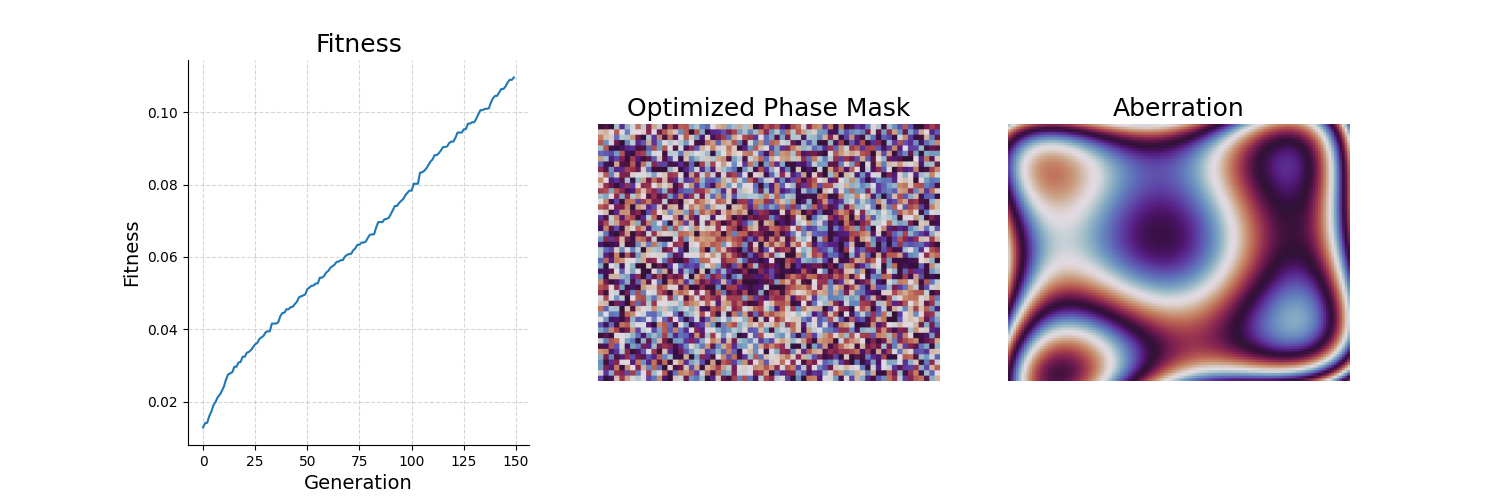

In [51]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

ax = axs[0]
ax.set_title("Fitness", fontsize = 18)
ax.plot(fitness_progress)
ax.set_xlabel("Generation", fontsize = 14)
ax.set_ylabel("Fitness", fontsize = 14)
ax.spines[['top', 'right']].set_visible(False)
ax.grid(visible = True, linestyle = '--', alpha = 0.5)

ax = axs[1]
ax.set_title("Optimized Phase Mask", fontsize = 18) 
ax.imshow(best_phase_mask, cmap = 'twilight')
ax.axis('off')

ax = axs[2]
ax.set_title("Aberration", fontsize = 18)
ax.imshow(aberration, cmap = 'twilight')
ax.axis('off')